# Finding maxima using optimization

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.transforms as mtransforms
import os
from pyphonon import *

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

%matplotlib widget

CUDA GPU Acceleration is unavailable for your system : (
Cupy Not available in your system. No GPU Support


In [3]:
# Create an estimator

# Simulator parameters
max_order   = 0
n_cores     = 20
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 0
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/1 [00:00<?, ?it/s]

Estimator Generated Successfully


In [21]:
# Create a better estimator

# Simulator parameters
max_order   = 2
n_cores     = 20
slow        = False

# Create estimator
G = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 2
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (CUDA GPU Acceleration is unavailable for your system : (

CUDA GPU Acceleration is unavailable for your system : (CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (CUDA GPU Acceleration is unavailable for your system : (


	Fast: 0, 0 Done!
	Fast: 1, 0 Done!
	Fast: 2, 0 Done!
	Fast: 1, 1 Done!
	Fast: 2, 1 Done!
	Fast: 2, 2 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/6 [00:00<?, ?it/s]

Estimator Generated Successfully


In [3]:
# Generate jacobian and hessian
print('Generating Jacobian')
JAC     = E.get_jacobian()
print('Generating Hessian')
HES     = E.get_hessian()

Generating Jacobian
Generating Hessian


In [5]:
# Calculate the maximum pressure given certain parameters
def max_pressure(r,v,l,E=E):
    # Initial token z position
    z   = 0.1

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    x0 = np.array([np.sqrt(r**2 + z**2),0])
    res = minimize(p,x0,method='nelder-mead', options={'xatol': 1e-9, 'disp': True})

    return -res['fun'], res['x'], res

# Calculate the maximum pressure given certain parameters
def max_pressure_single(r,v,l,E=E):
    # Initial token z position
    z   = 0.1

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    x0 = np.array([np.sqrt(r**2 + z**2),0])
    res = minimize(p,x0,method='nelder-mead', options={'xatol': 1e-9, 'disp': True})

    return -res['fun'], res['x'], res

# Calculate the maximum pressure given certain parameters and constraints
def max_pressure_constrained(r,v,l,JAC=None,HES=None,E=E):
    # Initial token z position
    z   = 0.1

    # Define constraints
    const   = lambda x: np.array(x[0] - np.sqrt(r**2 + x[1]**2))
    cjac    = lambda x: np.array([1,-x[1]/np.sqrt(r**2 + x[1]**2)])
    chess   = lambda x,v: v[0]*np.array([[0,0],[0,-r**2/np.sqrt(r**2+x[1]**2)**3]])
    
    constraint = NonlinearConstraint(const,0,np.inf,jac=cjac,hess=chess)

    # Get jacobian and hessian estimator
    if JAC is None:
        print('Generating Jacobian')
        JAC     = E.get_jacobian()
    if HES is None:
        print('Generating Hessian')
        HES     = E.get_hessian()

    # Jacobian and Hessian converters
    jac = lambda x: JAC(r,x[1],x[0],v,l)
    hes = lambda x: HES(r,x[1],x[0],v,l)

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    print('Starting Optimization')
    x0 = np.array([np.sqrt(r**2 + z**2)+0.0001,0])
    res = minimize(p,x0,method='trust-constr', #jac=jac, hess=hes, 
                    constraints=[constraint], options={'verbose': 1, 'disp': True})

    return -res['fun'], res['x'], res

# Plot the maximum
def plot_max(r,z,t,v,l,E=E,tol=0.01,Npts=10000):
    # Create a figure
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    # Get the time and plot everything
    T   = np.linspace(t-tol,t+tol,Npts)
    ax.plot(T,E(r,z,T,v,l))
    ax.axvline(t,c='k')
    ax.fill_between(T,0,1,v*T - (z+r*np.sqrt(v**2-1)) < 0,facecolor='red',alpha=0.1,transform=trans)

    return fig,ax

In [6]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]

Optimization terminated successfully.
         Current function value: -1.075412
         Iterations: 70
         Function evaluations: 134
 final_simplex: (array([[0.08617184, 0.00684174],
       [0.08617184, 0.00684174],
       [0.08617183, 0.00684174]]), array([-1.07541153, -1.07541153, -1.07541153]))
           fun: -1.075411527798921
       message: 'Optimization terminated successfully.'
          nfev: 134
           nit: 70
        status: 0
       success: True
             x: array([0.08617184, 0.00684174])


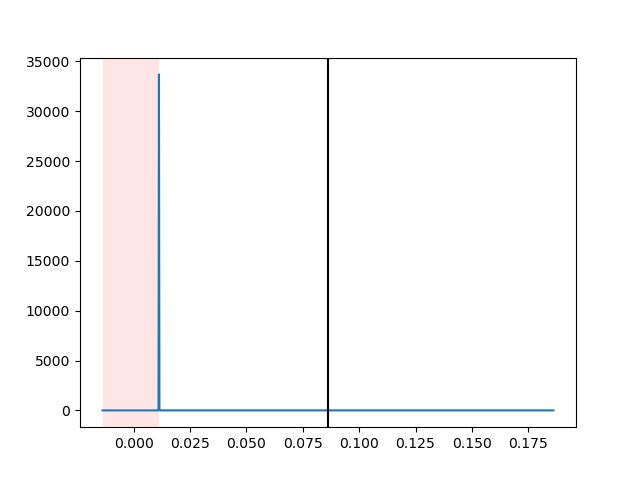

In [22]:
muon    = particles[0]
xe      = fluids[3]

muon(5*xe.sound_speed)
r = 1e-2
v = muon.speed/xe.sound_speed
l = xe.viscosity_coefficient()*xe.sound_speed

fun,x,res = max_pressure(r,v,l)
print(res)
fig,ax = plot_max(r,x[1],x[0],v,l,tol=.1,Npts=1000,E=G)

In [23]:
G(r,x[1],x[0],v,l)

1.07541541589394

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

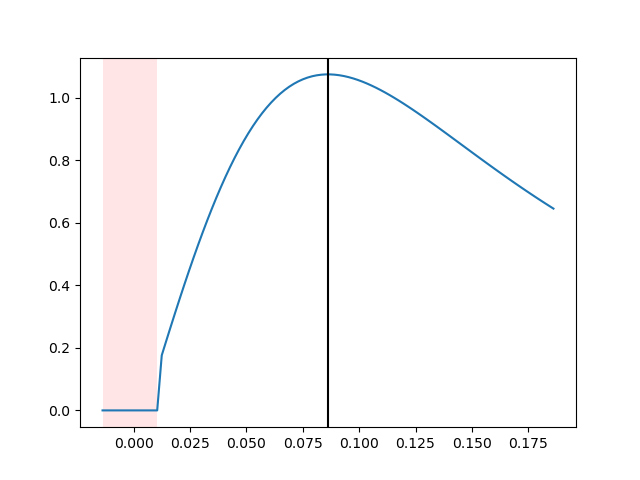

In [24]:
plot_max(r,x[1],x[0],v,l,tol=.1,Npts=100)

In [120]:
# muon    = particles[0]
# xe      = fluids[3]

# muon(10*xe.sound_speed)
# r = 100e-2
# v = muon.speed/xe.sound_speed
# l = xe.viscosity_coefficient()*xe.sound_speed

# fun,x,res = max_pressure_constrained(r,v,l,JAC=JAC,HES=HES)
# print(res)
# fig,ax = plot_max(r,x[1],x[0],v,l,tol=.1,Npts=100)

In [11]:
ax.axvline(np.sqrt(r**2 + x[1]**2),c='g')

(0.0, 1.0)

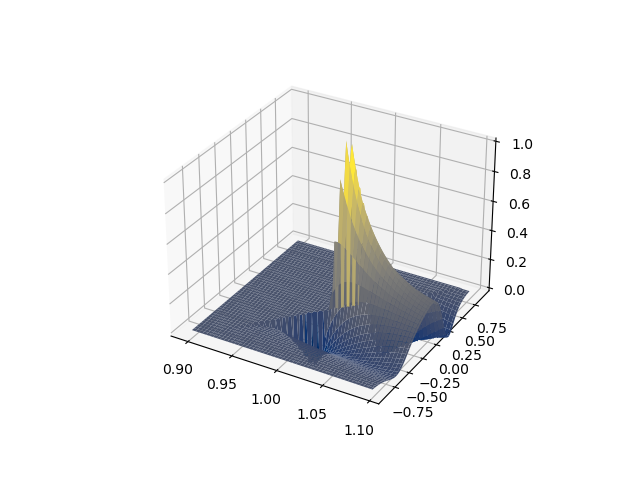

In [112]:
ttolerance = .1
ztolerance = 0.9
Npts=100
t = np.linspace(x[0]-ttolerance,x[0]+ttolerance,Npts)
z = np.linspace(x[1]-ztolerance,x[1]+ztolerance,Npts)
r = 100e-2
v = muon.speed/xe.sound_speed
l = xe.viscosity_coefficient()*xe.sound_speed

T,Z = np.meshgrid(t,z)
P = E(r,Z,T,v,l)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(T,Z,P,cmap=plt.cm.cividis)
ax.set_zlim(0,1)
